# Computer Vision MM 2025 - Practical 1 (v1.0)

## Instructions

1. Start Google Colab: https://colab.research.google.com. A modal dialog should have appeared to open a new notebook. If not, go to "File>Open notebook".
2. From the open notebook dialog, select the GitHub "tab" and enter this URL: https://github.com/chrirupp/cv_course
3. The notebook(s) should appear (*.ipynb). Select the one for the current practical.
4. To run a notebook on Colab you will typically need some data files (e.g., images). As Colab only loads the notebook itself, these other files need to be downloaded separately. The following cell is a `%%sh` block that downloads the required files. You can inspect the downloaded files by clicking on the "Files" tab on the left.

## Practicalities

The signing-off happens in the last half hour of each session or at the beginning of the following one.
As usual, when checking your work the demonstrator will want to see a working version of the program in action, as well as appropriate comments of your code. Try to make your report as concise as possible, perhaps in the form of appropriate comments to your code.

Since this is a new practical task, any errors, ambiguities or suggestions for improvement should be flagged as soon as possible.

If you are not familiar with the way practicals run, there are department-wide [rules](https://www.cs.ox.ac.uk/teaching/courses/2023-2024/practicals/). There you will find how the compulsory part, the optional tasks, and your report will factor into your mark.

## Advice

* You will need to look at the code for the lectures. There you will find many related computations that you can reuse and adapt to solve the practicals.
* The compulsory part of this practical is designed to give you additional understanding of the concepts taught in the lectures. It should be achievable in one session.

In [1]:
%%sh
# Download the data - you need to do this only once
wget --no-verbose --output-document=image.jpg https://github.com/chrirupp/cv_course/raw/main/data/image.jpg
wget --no-verbose --output-document=image_cc_1.jpg https://github.com/chrirupp/cv_course/raw/main/data/image_cc_1.jpg
wget --no-verbose --output-document=image_cc_2.jpg https://github.com/chrirupp/cv_course/raw/main/data/image_cc_2.jpg
wget --no-verbose --output-document=image_cc_3.jpg https://github.com/chrirupp/cv_course/raw/main/data/image_cc_3.jpg

2025-10-29 11:23:23 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/image.jpg [266057/266057] -> "image.jpg" [1]
2025-10-29 11:23:25 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/image_cc_1.jpg [12561742/12561742] -> "image_cc_1.jpg" [1]
2025-10-29 11:23:26 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/image_cc_2.jpg [13042668/13042668] -> "image_cc_2.jpg" [1]
2025-10-29 11:23:27 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/image_cc_3.jpg [15192593/15192593] -> "image_cc_3.jpg" [1]


Here we import some libraries that we will need to process images, do maths, and to visualise results.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from tqdm import tqdm
%matplotlib inline

Here are some helper functions that will help us visualise and analyse what is going on. This code is also found in the code for the lectures.

In [3]:
class Visualizer():
    def __init__(self, num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='', tight=False, cm=None):
        fig, self.axs = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
        # remove ticks
        if axis_off:
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        # set colormap
        if cm is not None:
            plt.set_cmap(cm)
        # set supertitle
        fig.suptitle(title)
        if tight:
            fig.subplots_adjust(top=0.88)

    def add_image_subplot(self, i, j, image, normalize=False, title_str=''):
        if normalize:
            image = self.normalize_image(image)
        if len(image.shape) == 3:
            #BGR -> RGB
            image = image[:, :, ::-1]
        self.axs[i, j].imshow(image)
        self.axs[i, j].set_title(title_str)

    def add_stem_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].stem(x, y)
        self.axs[i, j].set_title(title_str)

    def add_subplot(self, i, j, data, title_str=''):
        self.axs[i, j].plot(data)
        self.axs[i, j].set_title(title_str)

    def add_bar_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].bar(x, y)
        self.axs[i, j].set_title(title_str)

    @staticmethod
    def normalize_image(image):
        img = np.float64(image) - np.min(image)
        img /= np.max(img)
        return img

## Problem 1.1 - Template Matching

Let us do some template tracking. To begin, we will load an image and manually define a template.

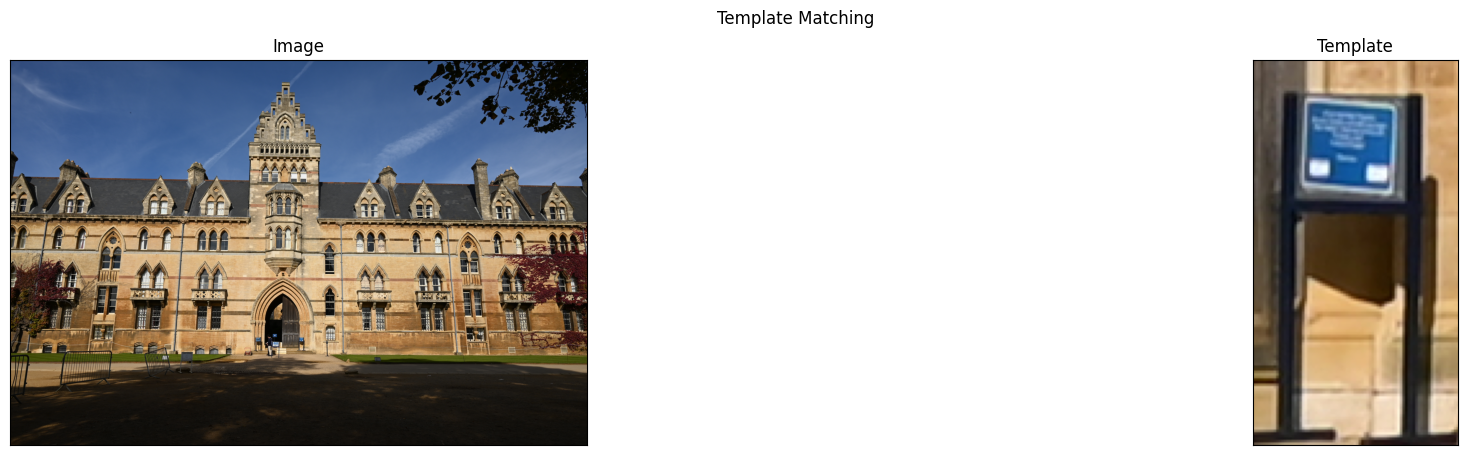

In [4]:
image = cv2.imread('image_cc_1.jpg')
template = image[2880:3030, 3000:3080]

vis = Visualizer(1, 2, figsize=(25,5), title='Template Matching')
vis.add_image_subplot(0, 0, image, title_str="Image")
vis.add_image_subplot(0, 1, template, title_str="Template")

Luckily, template matching is already implemented for us in OpenCV: `cv2` is a python wrapper around the C++ OpenCV library. This means that OpenCV implementations are usually much faster than anything you can implement in pure python.
`cv2.matchTemplate` accepts several options on the type of energy function to use. In sheet 1 and lecture 1 we have seen the sum of squared differences formulation, so we will try that first.

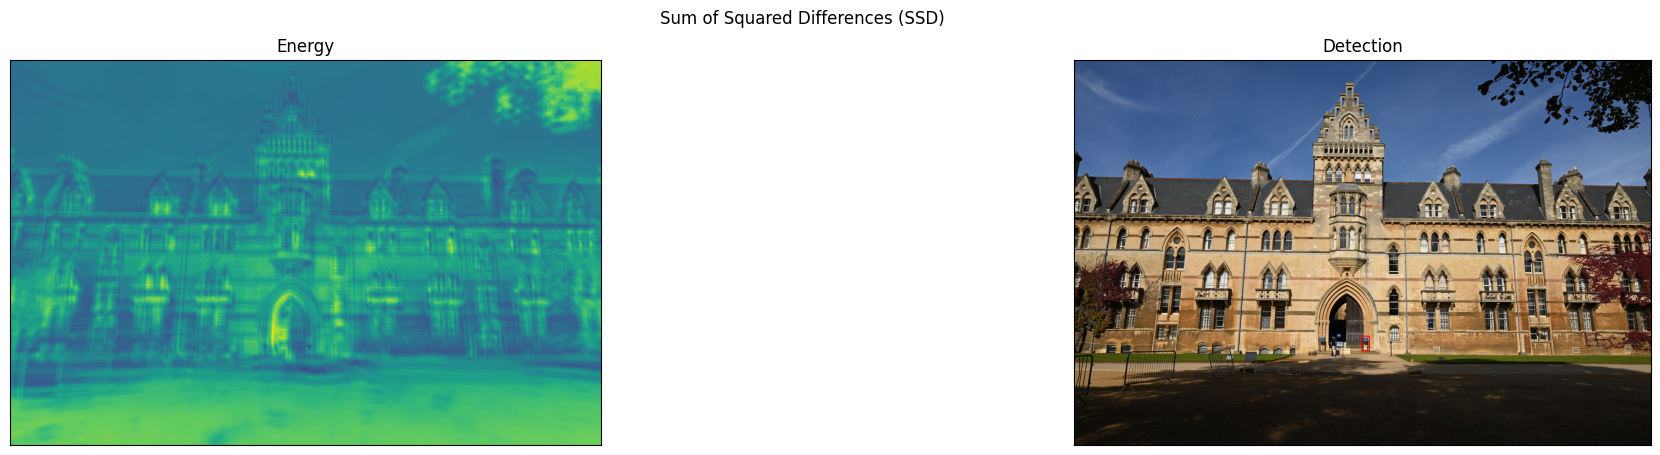

In [5]:
energy_ssd = cv2.matchTemplate(image, template, cv2.TM_SQDIFF)

# find minimum
detection = np.unravel_index(energy_ssd.argmin(), energy_ssd.shape)

# draw rectangle
result_image = image.copy()  # we do not want to draw on the original image
cv2.rectangle(result_image, (detection[1], detection[0]), (detection[1] + template.shape[1], detection[0] + template.shape[0]), (0,0,255), 10, 8, 0)

vis = Visualizer(1, 2, figsize=(25,5), title='Sum of Squared Differences (SSD)')
vis.add_image_subplot(0, 0, energy_ssd, title_str="Energy")
vis.add_image_subplot(0, 1, result_image, title_str="Detection")

To confirm your theoretical insights from Sheet 1, you can now test what happens when we modify the image. To do this, we will first need to convert the data type of the image from `uint8` (1 byte per pixel & channel) to `float32` (4 bytes per pixel and channel, floating point) so that scaling and offsets become easily possible and you do not need to deal with over/underflow.

Then test brightness and contrast changes to the image and show the detection. Does the detected location change when you do this?

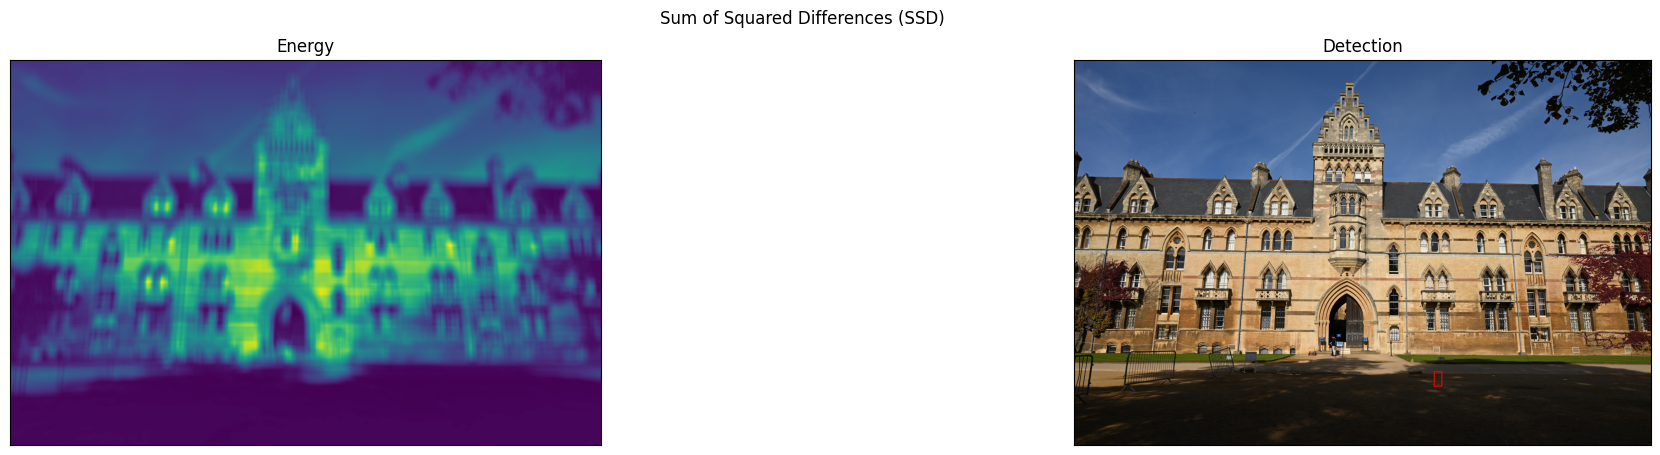

In [23]:
beta = 100
alpha = 3

float_image = alpha * np.float32(image)
float_template = np.float32(template)

energy_ssd = cv2.matchTemplate(float_image, float_template, cv2.TM_SQDIFF)

# find minimum
detection = np.unravel_index(energy_ssd.argmin(), energy_ssd.shape)

# draw rectangle
result_image = image.copy()  # we do not want to draw on the original image
cv2.rectangle(result_image, (detection[1], detection[0]), (detection[1] + float_template.shape[1], detection[0] + float_template.shape[0]), (0,0,255), 10, 8, 0)

vis = Visualizer(1, 2, figsize=(25,5), title='Sum of Squared Differences (SSD)')
vis.add_image_subplot(0, 0, energy_ssd, title_str="Energy")
vis.add_image_subplot(0, 1, result_image, title_str="Detection")
# vis.add_image_subplot(0, 1, np.uint8(float_image), title_str="modified image")

We have also discussed that the sum of squared differences cannot be implemented as a convolution. However, if we change the energy function from SSD to cosine distances between template and image we can get there. We will define the following energy:

$$E(x,y) = \frac{\sum_{i,j} I(x+i, y+j) \cdot T(i, j)}{\sqrt{\sum_{i,j} I(x+i, y+j)^2 \cdot \sum_{i,j} T(i, j)^2}} $$

The denominator normalises the _length_ of the "image patch vector" and the "template vector" to one (intuitively we can treat the image patch and the template as a vector here).

OpenCV has implemented this energy function for us too. It is often also called normalised cross-correlation which explains the option name `cv2.TM_CCORR_NORMED`.

Perform template matching with cosine distances and show the result. Remember that we have switched from SSD to cosine as our energy function, so we are now looking for a maximum!

In [ ]:
# TODO: compute cosine similarity energy function
# TODO: find detection
# TODO: visualise
beta = 100
alpha = 3

float_image = alpha * np.float32(image)
float_template = np.float32(template)

energy_ssd = cv2.matchTemplate(float_image, float_template, cv2.TM_SQDIFF)

# find minimum
detection = np.unravel_index(energy_ssd.argmin(), energy_ssd.shape)

# draw rectangle
result_image = image.copy()  # we do not want to draw on the original image
cv2.rectangle(result_image, (detection[1], detection[0]), (detection[1] + float_template.shape[1], detection[0] + float_template.shape[0]), (0,0,255), 10, 8, 0)

vis = Visualizer(1, 2, figsize=(25,5), title='Sum of Squared Differences (SSD)')
vis.add_image_subplot(0, 0, energy_ssd, title_str="Energy")
vis.add_image_subplot(0, 1, result_image, title_str="Detection")
# vis.add_image_subplot(0, 1, np.uint8(float_image), title_str="modified image")

There are three important concepts that you can explain/experiment with now.
* Why do we need to normalise? (The unnormalised version is available with `cv2.TM_CCORR`)
* How can we implement the cosine distance energy with convolution(s)? (motivation: GPUs can do convolutions really fast) You do not need to show an implementation for this question.
* How do brightness changes $\beta I$ affect the energy/its maximum?

## Problem 1.2 - Homographies and SIFT Keypoints

In the lecture we have discussed that keypoints should be stable under a wide variety of typical image transformations. In this exercise we will benchmark this for SIFT keypoints.
The benchmark will look like this:
* pick an image and detect SIFT keypoints.
* for a fixed number of samples:
    * sample a random image transformation.
    * transform the image with this transformation.
    * compute keypoints on the transformed image.
    * compute where the transformation actually maps the keypoints to. These are our ground truth targets.
    * for each ground truth target, check if a keypoint was detected _close by_.
* compute the percentage of keypoints that can be rediscovered.

We will approach this problem in steps. First write a function that samples a random transformation.

In [ ]:
def random_rotation_transformation():
    # return a random rotation matrix
    angle = np.random.uniform(-10, 10) / 180 * np.pi
    mat_rot = None  # TODO: compute a 3x3 rotation matrix
    return mat_rot

To test the function, we will apply it to an image and show some samples.

In [ ]:
img = cv2.imread("image.jpg")
vis = Visualizer(1, 5, figsize=(25,5), title='transformations')
for i in range(5):
    vis.add_image_subplot(0, i, cv2.warpPerspective(img, random_rotation_transformation(), (img.shape[1], img.shape[0])))

Let us now write a function that
* loads an image
* detects SIFT keypoints
* warps the image
* warps the keypoints (do not forget to homogenise the points after warping!)
* detects SIFT keypoints on the new image
The function will return the detected and the target keypoints that we can then evaluate.

In [ ]:
def detect_and_warp(transform):
    img = cv2.imread("image.jpg", cv2.IMREAD_GRAYSCALE)  # load image
    sift = cv2.SIFT_create()
    kp, _ = sift.detectAndCompute(img, None)  # detect keypoints

    img_warped = None  # TODO: warp the image
    kp_detected, _ = sift.detectAndCompute(img_warped, None)  # detect keypoints in warped image

    kp_warped = copy.copy(kp)
    for i, k in enumerate(kp):
        kp_warped[i].pt = None  # TODO: warp the keypoints here. You can access the coordinates with k.pt

    return kp, kp_warped, kp_detected, img, img_warped

# test the code you have written:
transform = random_rotation_transformation()
kp, kp_warped, kp_detected, img, img_warped = detect_and_warp(transform)
vis = Visualizer(1, 3, figsize=(25,5), title='SIFT Keypoints')
vis.add_image_subplot(0, 0, cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT))
vis.add_image_subplot(0, 1, cv2.drawKeypoints(img_warped, kp_detected, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT))
vis.add_image_subplot(0, 2, cv2.drawKeypoints(img_warped, kp_warped, None, flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT))

Finally we need to compute the accuracy for a given distance threshold. Make sure to ignore warped keypoints that would lie outside the image.

In [ ]:
def accuracy(kp_warped, kp_detected, img, threshold=10):
    # to facilitate the computation, we convert the keypoints to a numpy array
    detections = np.zeros((len(kp_warped), 2))
    for i, k in enumerate(kp_warped):
        detections[i, :] = np.array(k.pt)
    # TODO: remove points outside of image
    # TODO: count number of detections that are within threshold distance of the original keypoint
    return 0  # TODO: return the accuracy (0-1)

transform = random_rotation_transformation()
_, kp_warped, kp_detected, img, _ = detect_and_warp(transform)
print(f"Accuracy: {accuracy(kp_warped, kp_detected, img)*100:.2f}%")

Finally, we will compute the average over many (=20) samples. For rotations ($\pm 10 degrees, uniform) around the top-left corner of the image you should get about 97% accuracy with a threshold of 10 px.

In [ ]:
def evaluate_transform(transform, num_iterations=20):
    return 0 # TODO: return the average accuracy over num_iterations. You can use tqdm to show a progress bar.

print(f"Accuracy: {evaluate_transform(random_rotation_transformation)*100:.2f}%")

### Optional Task
Implement a random homography transform. A good way to sample meaningful homographies is to compute them from point correspondences. Take 4 points in a 100x100 square and match them to a randomly perturbed square ($\pm$ 10px) with a homography.

In [ ]:
def random_homography_transformation():
    # TODO: return a random homography matrix
    return None

img = cv2.imread("image.jpg")
vis = Visualizer(1, 5, figsize=(25,5), title='homographies')
for i in range(5):
    vis.add_image_subplot(0, i, cv2.warpPerspective(img, random_homography_transformation(), (img.shape[1], img.shape[0])))
print(f"Accuracy: {evaluate_transform(random_homography_transformation)*100:.2f}%")

### Optional Task
Instead of using `cv2.findHomography`, compute the homography yourself using `np.svd`. Setup $A$ and solve for $Ah=0$. Compare your output to `cv2.findHomography`. OpenCV normalises homographies such that $h_{3,3}=1$.

In [ ]:
def homography_svd():
    pointsA = np.float32([[0, 0, 1], [0, 100, 1], [100, 100, 1], [100, 0, 1]]).reshape(4, 3)
    pointsB = np.ones_like(pointsA)
    pointsB[:, :2] = pointsA[:, :2] + np.random.uniform(-10, 10, size=pointsA[:, :2].shape)

    h_cv2, status = cv2.findHomography(pointsA, pointsB)
    # TODO: now with svd:
    h_svd = None
    return h_cv2, h_svd

h_cv2, h_svd = homography_svd()
print(f"cv2 homography:\n{h_cv2}")
print(f"svd homography:\n{h_svd}")

### Optional Task
Visualise some patches around keypoints where the matching failed. What do you observe?

## Problem 1.3 - Image Stitching and RANSAC

In the lecture we have seen how we can use homographies to warp images. We will now use SIFT to obtain point correspondences to estimate a homography between to images. We can then use the estimated homography to stitch images into a panorama.

We will start where the lecture left off: we compute a homography from manual correspondences to show that the stitched image is reasonable. The reason why `stitch_images()` below is so lengthy is that we need to be careful with our coordinate systems. Since $[0,0]$ is always the first element in a numpy array, we need to convert between pixel coordinates and array indices after applying the homography. We do this by transforming the 4 corners of one image to the other which will give us the the mapping between array indices and coordinates so that we can blend the images properly.

In [ ]:
def stitch_images(img2, img1, homography):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
    corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
    warped_corners2 = cv2.perspectiveTransform(corners2, homography)

    corners = np.concatenate((corners1, warped_corners2), axis=0)
    [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)

    t = [-xmin, -ymin]
    Ht = np.array([[1, 0, t[0]], [0, 1, t[1]], [0, 0, 1]])

    warped_img2 = cv2.warpPerspective(img2, Ht @ homography, (xmax - xmin, ymax - ymin))
    warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] = warped_img2[t[1]:h1 + t[1], t[0]:w1 + t[0]] // 2 + img1 //2

    return warped_img2

downsample = 0.25  # to make things faster we will resize the images
points1 = np.float32([[2597, 1004], [3123, 1013], [3140, 1275], [2577, 1268]]).reshape(4, 2) * downsample
points2 = np.float32([[1165, 726], [1770, 828], [1768, 1109], [1115, 1009]]).reshape(4, 2) * downsample

homography, status = cv2.findHomography(points1, points2)

image1_color = cv2.resize(cv2.imread('image_cc_1.jpg'), (0,0), fx=downsample, fy=downsample)
image2_color = cv2.resize(cv2.imread('image_cc_2.jpg'), (0,0), fx=downsample, fy=downsample)

# visualize the result
vis = Visualizer(1, 1, figsize=(25,5), title='Stitching')
vis.add_image_subplot(0, 0, stitch_images(image1_color, image2_color, homography))

You can see that the resulting overlay is ok but not perfect iin many places (e.g. the right side).
Let us see if we can improve this with SIFT correspondences.

We use the code from the lecture as a basis to compute SIFT correspondences between the two images.
Additionally, we will apply the _ratio-test_ from the original SIFT paper to filter out bad matches: for each keypoint we check the feature distance between its feature and its match in the other image and compare it to its second best match. If the feature distance between best and second-best match is similar, we likely have a keypoint that matches in many places and we want to discard it. We will use a distance ratio threshold of 0.75 here.

* Since we only need 4 correspondences to estimate a homography, randomly pick 4 point pairs (`np.random.choice()`) to compute the estimate.
* Visualize the stitching and run it several times since there is randomness involved. Why does this only sometimes work well?

In [ ]:
image1_gray = cv2.cvtColor(image1_color, cv2.COLOR_BGR2GRAY)
image2_gray = cv2.cvtColor(image2_color, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(image1_gray, None)
kp2, des2 = sift.detectAndCompute(image2_gray, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)  # this gives us the two best matches per descriptor
# Apply ratio test
good_matches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)
print(f"{len(good_matches)}/{len(matches)} matches after ratio test")
matches = good_matches

matches_img = cv2.drawMatches(image1_color,kp1,image2_color,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
vis = Visualizer(1, 1, figsize=(25,5), title='Matches')
vis.add_image_subplot(0, 0, matches_img)

# TODO: randomly select 4 matches and compute a homography from them
homography = None
vis = Visualizer(1, 1, figsize=(25,5), title='Stitching')
vis.add_image_subplot(0, 0, stitch_images(image1_color, image2_color, homography))

RANdom SAmple Consensus (RANSAC) to the rescue! The idea is simple: we keep selecting 4 random point pairs many times and return the _best_ homography that we could find in the end. We resort to randomness because the number of possible ways to select 4 correspondences is much too large to try them exhaustively. We do not want to compute an "average" homography of some sorts because this would be very much affected by wrong or bad matches.

The only question that remains is how we measure the quality of a homography. Again the idea is simple: after computing the homography we use it to warp all the points from one image to the other. We can then count how many other points land close to their designated matches (we call these inliers). A good homography will have many inliers.

In [ ]:
def ransac(kp1, kp2, matches, num_iterations=1000, threshold=0.5):
    best_homography = None
    # TODO: implement RANSAC here. Print the number of inliers whenever you find a better homography
    return best_homography

homography = ransac(kp1, kp2, matches)
vis = Visualizer(1, 1, figsize=(25,5), title='Stitching with RANSAC')
vis.add_image_subplot(0, 0, stitch_images(image1_color, image2_color, homography))

### Optional Tasks

* loops in python are quite slow. Find a way to implement the inlier counting with numpy operations on arrays. (Hint: `np.sum(A < 5)` counts all elements in `A` that are less than 5.)
* stitch a third image (`image_cc_3.jpg`) to the two previous ones.